<a href="https://colab.research.google.com/github/JonathanChavezTamales/AetherPageRank/blob/master/NPZ_Event_To_Image_Converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convertidor de eventos .npz a imagen

Autor: Jonathan Chávez

Aquí he creado las funciones utilizadas para pasar eventos de archivos .npz a 
imagenes donde cada PMT es un pixel (cilindro desenrollado sin tapas).




In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

## Convertir coordenadas de geometría a matriz de IDs

Para poder generar una imagen donde cada PMT es representado como un pixel, se necesita mapear cada coordenada en el espacio del PMT a un pixel del plano.

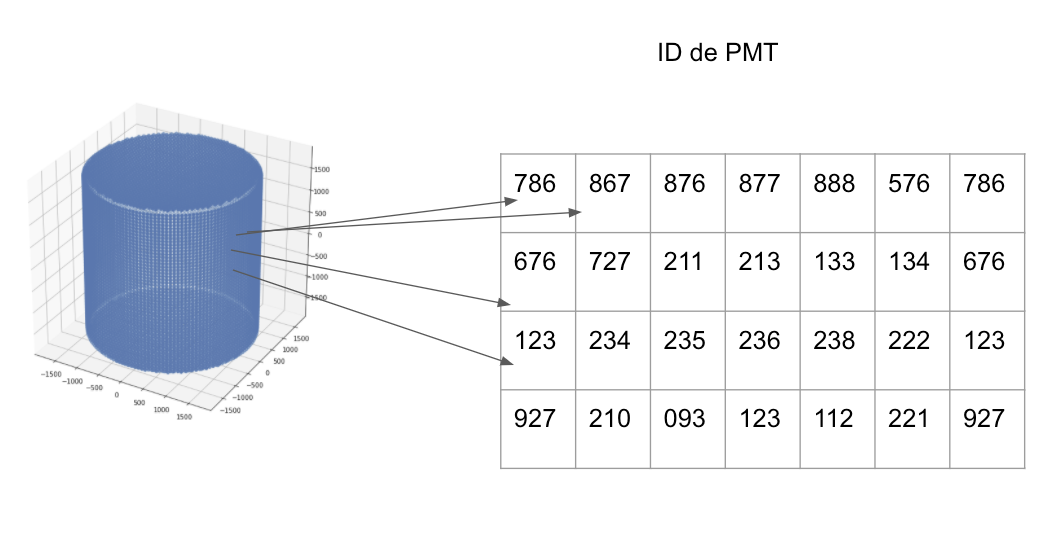

Para ello se utiliza la siguiente función que recibe el archivo de geometría .npz y retorna una matriz donde cada pixel es un pmt del barril.

In [ ]:
geo = np.load('SK_geo.npz', allow_pickle=True)

FileNotFoundError: ignored

In [ ]:
def to_cylindrical(coords):
  x, y, z = coords[0], coords[1], coords[2]
  ro = sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  return  ro, theta, z

def unroll_geometry(geo_file):

  # Se pasan posicion de PMT a coordenadas cilíndricas
  cyl_coords = np.array([to_cylindrical(coords) for coords in geo_file['position']])

  # Se crea un Dataframe con las posiciones y IDs y se ordena por z y theta
  pmt_pos = {
      'id': geo_file['tube_no'],
      'theta': cyl_coords[:, 1],
      'z': geo_file['position'][:,2],
  }
  pmt_pos = pd.DataFrame(pmt_pos)
  pmt_pos = pmt_pos.sort_values(by=['z', 'theta'])

  # Quitamos las tapas
  pmt_pos = pmt_pos[abs(pmt_pos['z']) < 1750]

  # Generación de la matriz de IDs
  image = [[ int(pmt_pos.iloc[0]['id']) ]]
  current_row = 0
  last_z = pmt_pos.iloc[0]['z']

  # Se recorren los PMTs a lo largo de theta ordenados por z
  for i in range(1, len(pmt_pos)):
    pmt = pmt_pos.iloc[i]
    # Cuando cambia z, significa que están en la siguiente fila
    if abs(last_z - pmt['z']) > 0.001 :
      image.append([])
      current_row += 1
    last_z = pmt['z']
    image[current_row].append(int(pmt['id']))

  return np.array(image)

In [ ]:
image = unroll_geometry(geo)
image.shape

In [ ]:
# Así se ven distribuidos los ID
plt.imshow(image)

In [ ]:
# Guardamos esta "máscara" de IDs para no tenerla que calcular nuevamente
np.save('sk-pmtpos.npy', image)

Por lo tanto la función que se utilizará es `unroll_geometry` y la "máscara" de IDs.

## Convertir evento WCSim a imagen

Ahora convertiremos el evento a imagen. 

El array resultante tiene la forma `(#eventos, 150, 51, 2)`, es decir, el número de imágenes es el número de eventos simulados y cada imagen es de 150x51
con dos canales: corriente recibida por PMT y tiempo en el que se activó.

In [ ]:
# Se carga la máscara generada anteriormente, que sirve para identificar la posición de los PMTs en la imagen.
mask = np.load('sk-pmtpos.npy')

# Se carga también el .npz con los eventos
data = np.load('1000_mu-_250MeV.npz', allow_pickle=True)

print(data['pid'][0])
# 11 - electron, 13 - muon, 22 - gamma 

13


In [ ]:
# Convertimos el evento deseado a dataframe

event = {
  'id': data['digi_hit_pmt'][0],
  'charge': data['digi_hit_charge'][0],
  'time': data['digi_hit_time'][0],
}

event = pd.DataFrame(event)

In [ ]:
# Primero se preprocesa la máscara para hacerla de acceso aleatorio con llave valor
# Llave (PMT_id) -> Valor ((x, y) en máscara)

map = {  }

for i in range(len(mask)):
  for j in range(len(mask[i])):
    pmt_id = mask[i][j]
    map[pmt_id] = (i, j)

In [ ]:
def to_image(event):
  """ Recibe Dataframe de evento (id, charge, time) y retorna una matriz de la imagen"""
  # Se crea una matriz del tamaño del tanque desenrollado (mismo tamaño que máscara)
  # pero con dos canales: (corriente, tiempo de activación)
  event_image = np.zeros(mask.shape + (2,))

  # Se itera sobre cada pmt activado en el evento
  for index, pmt in event.iterrows():
    id = pmt['id']
    charge = pmt['charge']
    time = pmt['time']

    # Si el pmt activado no está en la tapa, se actualizan los valores
    if id in map:
      (i_mask, j_mask) = map[id]
      event_image[i_mask][j_mask] = np.array([charge, time])

  return event_image

In [ ]:
event_image = to_image(event)

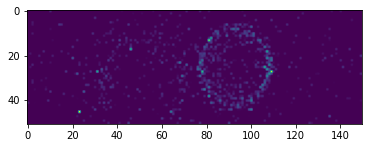

In [ ]:
plt.imshow(event_image[:, :, 0])

## Pipeline completo

Ahora se realiza la conversión de múltiples eventos a imagenes usando las herramientas previamente definidas.

In [ ]:
images = []

for i in data['event_id']:
  print('Processing event ', i)

  event = {
    'id': data['digi_hit_pmt'][i],
    'charge': data['digi_hit_charge'][i],
    'time': data['digi_hit_time'][i],
  }

  event = pd.DataFrame(event)
  images.append(to_image(event))

images = np.array(images)

Processing event  0
Processing event  1
Processing event  2
Processing event  3
Processing event  4
Processing event  5
Processing event  6
Processing event  7
Processing event  8
Processing event  9
Processing event  10
Processing event  11
Processing event  12
Processing event  13
Processing event  14
Processing event  15
Processing event  16
Processing event  17
Processing event  18
Processing event  19
Processing event  20
Processing event  21
Processing event  22
Processing event  23
Processing event  24
Processing event  25
Processing event  26
Processing event  27
Processing event  28
Processing event  29
Processing event  30
Processing event  31
Processing event  32
Processing event  33
Processing event  34
Processing event  35
Processing event  36
Processing event  37
Processing event  38
Processing event  39
Processing event  40
Processing event  41
Processing event  42
Processing event  43
Processing event  44
Processing event  45
Processing event  46
Processing event  47
Pr

Ahora se tienen 20 imagenes de 150x51 de dos canales.

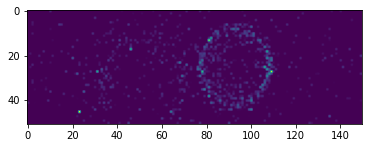

In [ ]:
plt.imshow(images[0, :, :, 0])

In [ ]:
images.shape

(1000, 51, 150, 2)

In [ ]:
np.save('1000_mu-_250MeV_IMG.npy', images)

## Experimentos

Aplico funciones de manera agregada con los 20 eventos

**NOTA:** Al parecer hay un error el mapeo, en la parte derecha hay unos sensores activados que no deberían estarlo.

In [ ]:
images_electron = np.load('20_e-_250Mev_IMG.npy')
images_gamma = np.load('20_gamma_250Mev_IMG.npy')

Ahora a visualizar cada uno

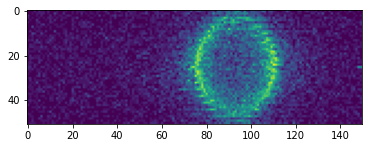

In [ ]:
# Promedio de tiempo de activaciones
result = np.mean(images_electron, axis=0)
plt.imshow(result[:, :, 1])

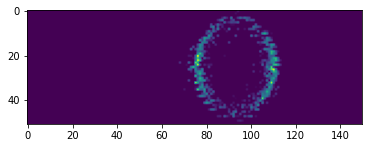

In [ ]:
# Mediana de energías

result = np.median(images_electron, axis=0)
plt.imshow(result[:, :, 0])

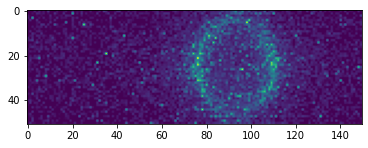

In [ ]:
# Máximo de energías de cada PMT

result = np.max(images_electron, axis=0)
plt.imshow(result[:, :, 0])

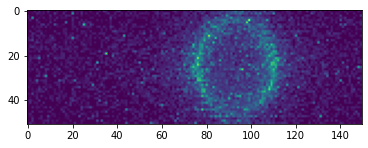

In [ ]:
# Desviación estándar de energías por pmt

result = np.std(images_electron, axis=0)
plt.imshow(result[:, :, 0])

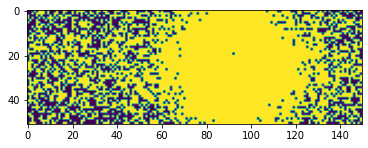

In [ ]:
# OR de activaciones
result = images_electron[0]
for i in range(1, len(images_electron)):
  result = np.logical_or(result, images_electron[i])
plt.imshow(result[:, :, 0])

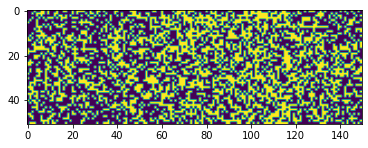

In [ ]:
# XOR de activaciones
result = images_electron[0]
for i in range(1, len(images_electron)):
  result = np.logical_xor(result, images_electron[i])
plt.imshow(result[:, :, 0])

### Intento de clasificación manual e-/gamma

- Resta de funciones agregadas, ejemplo: mean(e-) - mean(gamma)
- Xor de funciones agregaddas, ejemplo: median(e) XOR median(gamma)

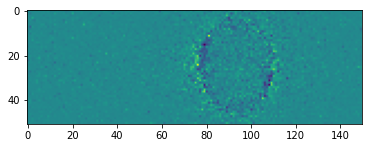

In [ ]:
# Resta de las medias de energía (al parecer el anillo de electrón es un poco más grande que el de gamma)
result = np.mean(images_electron, axis=0) - np.mean(images_gamma, axis=0)
plt.imshow(result[:, :, 0])

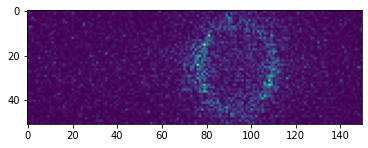

In [ ]:
# Diferencia absoluta entre las dos medias, sí existe la diferencia, está en las partes opuestas más cercanas de la elipse.
result = np.abs(np.mean(images_electron, axis=0) - np.mean(images_gamma, axis=0))
plt.imshow(result[:, :, 0])

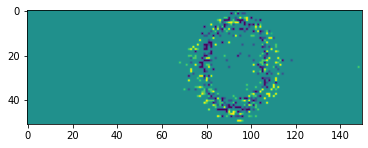

In [ ]:
# Diferencia de medianas da mucha información cuando la mediana es el tiempo, una elipse es diferente a otra
result = np.median(images_electron, axis=0) - np.median(images_gamma, axis=0)
plt.imshow(result[:, :, 1])

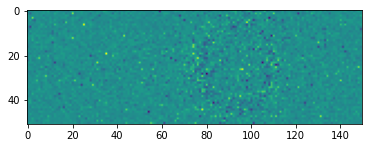

In [ ]:
result = np.max(images_electron, axis=0) - np.max(images_gamma, axis=0)
plt.imshow(result[:, :, 0])

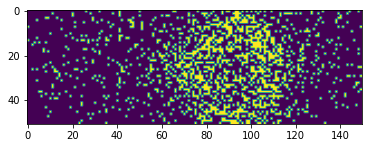

In [ ]:
result_a = images_electron[0]
for i in range(1, len(images_electron)):
  result_a = np.logical_xor(result, images_electron[i])

result_b = images_gamma[0]
for i in range(1, len(images_gamma)):
  result_b = np.logical_xor(result, images_gamma[i])

plt.imshow(np.logical_xor(result_a[:, :, 0],  result_b[:, :, 0]))